<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/RandomForestClassifier/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Random Forest Classifier

In [1204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Tratamento de dados

In [1205]:
# Obtenção dos Dados
# Usando 'period' para pegar os dados dos últimos 2 anos
dados = pd.read_csv('https://raw.githubusercontent.com/willianncardoso/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
1,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"
2,02.07.2025,139.051,139.586,140.049,138.384,"8,81B","-0,36%"
3,01.07.2025,139.549,138.855,139.695,138.855,"6,35B","0,50%"
4,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"


In [1206]:
def converter_volume_simples(valor):
    # Deixa tudo maiúsculo, troca vírgula por ponto e remove espaços
    valor_str = str(valor).upper().replace(',', '.').strip()

    if 'B' in valor_str:
        return int(float(valor_str.replace('B', '')) * 1_000_000_000)
    elif 'M' in valor_str:
        return int(float(valor_str.replace('M', '')) * 1_000_000)
    else:
        # Se não tiver letra, apenas converte para número
        return int(float(valor_str))

dados['Vol.'] = dados['Vol.'].apply(converter_volume_simples)

# Convertendo a data formato
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y')

# Inverter Data Ascending
dados.sort_values(by='Data', ascending=True, inplace=True)

# Data como índice
dados.set_index('Data', inplace=True)


In [1207]:
dados['Var%'] = pd.to_numeric(dados['Var%'].str.replace('%', '').str.replace(',', '.')) / 100

dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2023-06-30 to 2025-07-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    502 non-null    float64
 1   Abertura  502 non-null    float64
 2   Máxima    502 non-null    float64
 3   Mínima    502 non-null    float64
 4   Vol.      502 non-null    int64  
 5   Var%      502 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [1208]:
# 2. Engenharia de Atributos para Classificação

# Criando a variável-alvo (Target)
# 1 se o preço de fechamento de amanhã for MAIOR que o de hoje, 0 caso contrário
dados['Target'] = (dados['Último'].shift(-1) > dados['Último']).astype(int)

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [1209]:
print("Removendo a feature com vazamento de dados: 'Var%'")
# Use o nome exato da sua coluna de variação aqui
# O 'errors='ignore'' evita um erro caso a coluna não exista ou já tenha sido removida
dados.drop(columns=['Var%'], inplace=True, errors='ignore')

Removendo a feature com vazamento de dados: 'Var%'


In [1210]:
# criação de uma feature de variação segura, que olha para o passado.
dados['Variacao_Dia_Anterior'] = dados['Último'].pct_change()

# Isso vai criar um NaN na primeira linha, então
# é importante rodar o dropna() depois de criar todas as features
dados.dropna(inplace=True)

dados

,Último,Abertura,Máxima,Mínima,Vol.,Target,Variacao_Dia_Anterior
Data,,,,,,,
2023-07-03,119.673,118.092,119.877,118.092,8910000,0,0.013431
2023-07-04,119.076,119.673,119.678,118.830,6560000,1,-0.004989
2023-07-05,119.549,119.072,120.200,118.688,10960000,0,0.003972
2023-07-06,117.426,119.548,119.548,117.096,11030000,1,-0.017758
2023-07-07,118.898,117.427,119.549,117.427,10520000,0,0.012536
...,...,...,...,...,...,...,...
2025-06-30,138.855,136.865,139.103,136.430,7680000000,1,0.014532
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0,0.004998
2025-07-02,139.051,139.586,140.049,138.384,8810000000,1,-0.003569


## Primeiro teste do modelo

In [1211]:
# 4. Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 400 amostras
Tamanho do conjunto de Teste: 101 amostras


In [1212]:
print("--- Verificando as colunas em X antes do treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X antes do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior']


In [1213]:
# Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [1214]:
print("--- Verificando as colunas em X UTILIZADAS no treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X UTILIZADAS no treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior']



--- Resultados da Avaliação ---
Acurácia do Modelo: 49.50%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       0.46      0.87      0.60        45
       Subiu (1)       0.65      0.20      0.30        56

        accuracy                           0.50       101
       macro avg       0.56      0.53      0.45       101
    weighted avg       0.57      0.50      0.44       101


Matriz de Confusão:


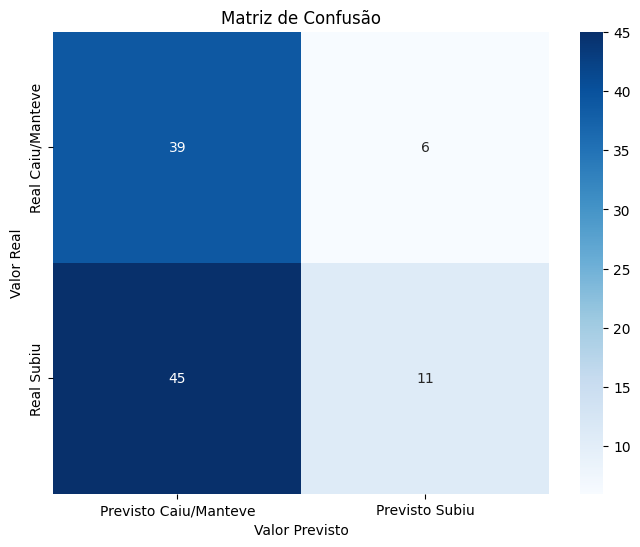

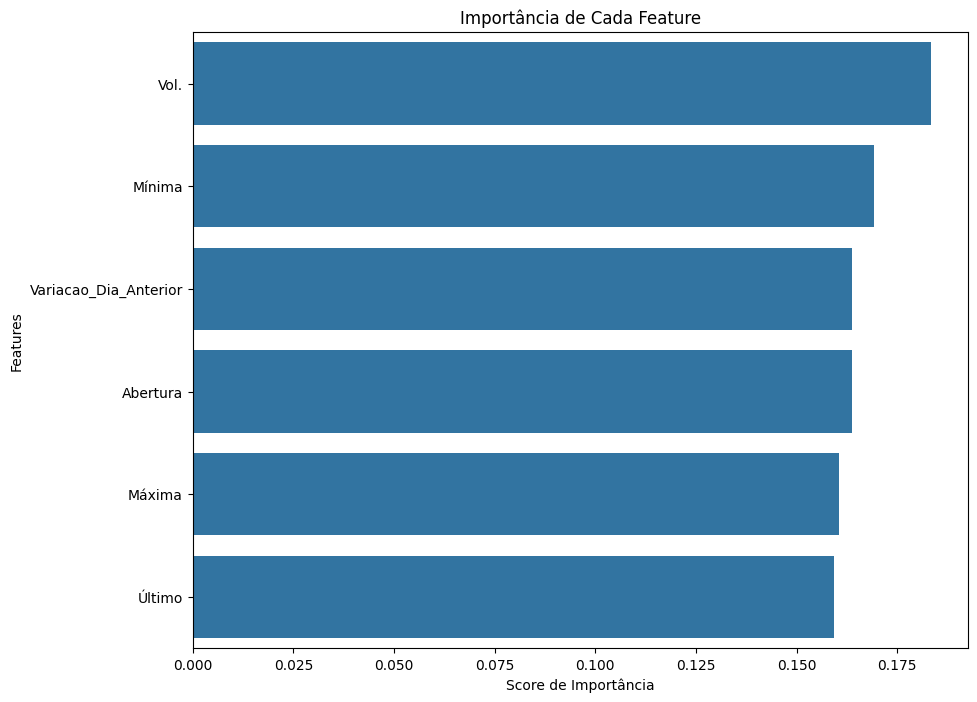

In [1215]:
# Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()

In [1216]:
# Adicionanado as features de contexto (SP&500, Dólar, etc.)
# =================================================================
print("\nIniciando a Etapa de Enriquecimento de Features...")

# Usaremos o seu DataFrame 'dados' já ordenado e com o índice correto
tickers_contexto = {
    'SP500': '^GSPC',      # Mercado Americano
    'DOLAR': 'USDBRL=X',   # Câmbio
    'PETROLEO': 'CL=F'     # Commodities
}

for nome, ticker in tickers_contexto.items():
    print(f"Buscando dado de contexto: {nome} ({ticker})")
    # Pega a variação diária do preço de fechamento do ativo de contexto
    # e a adiciona como uma nova coluna no seu DataFrame 'dados'
    dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()



/tmp/ipython-input-1216-232372794.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1216-232372794.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1216-232372794.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed


Iniciando a Etapa de Enriquecimento de Features...
Buscando dado de contexto: SP500 (^GSPC)
Buscando dado de contexto: DOLAR (USDBRL=X)
Buscando dado de contexto: PETROLEO (CL=F)


## Adicionando mais dados BOVESPA

In [1217]:
# Criando features de Lag para o contexto
# =================================================================
features_de_contexto = ['Var_SP500', 'Var_DOLAR', 'Var_PETROLEO']
for feature in features_de_contexto:
    # Criando um lag de 1 dia para cada feature de contexto
    dados[f'{feature}_Lag_1'] = dados[feature].shift(1)

In [1218]:
# Limpeza Final
# =================================================================
# Após adicionar todas as novas features, removemos as linhas com valores NaN
# que foram criadas pelos cálculos de .pct_change() e .shift()
dados.dropna(inplace=True)

In [1219]:
dados

,Último,Abertura,Máxima,Mínima,Vol.,Target,Variacao_Dia_Anterior,Var_SP500,Var_DOLAR,Var_PETROLEO,Var_SP500_Lag_1,Var_DOLAR_Lag_1,Var_PETROLEO_Lag_1
Data,,,,,,,,,,,,,
2023-07-06,117.426,119.548,119.548,117.096,11030000,1,-0.017758,-0.007923,0.001508,0.000139,-0.001968,0.006949,0.028657
2023-07-07,118.898,117.427,119.549,117.427,10520000,0,0.012536,-0.002865,0.014751,0.028691,-0.007923,0.001508,0.000139
2023-07-10,117.942,118.897,118.897,117.814,8100000,0,-0.008041,0.002405,-0.009718,-0.011779,-0.002865,0.014751,0.028691
2023-07-11,117.556,117.942,117.942,115.704,10590000,1,-0.003273,0.006742,0.005605,0.025209,0.002405,-0.009718,-0.011779
2023-07-12,117.666,117.557,119.156,117.557,8940000,1,0.000936,0.007411,-0.009534,0.012295,0.006742,0.005605,0.025209
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,136.866,137.113,137.209,136.469,6240000000,1,-0.001809,0.005219,-0.014538,0.004292,0.008020,0.008638,0.004929
2025-06-30,138.855,136.865,139.103,136.430,7680000000,1,0.014532,0.005164,0.000237,-0.006258,0.005219,-0.014538,0.004292
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0,0.004998,-0.001119,-0.008798,0.005222,0.005164,0.000237,-0.006258


In [1220]:
print("--- Verificando as colunas em X ANTES do treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X ANTES do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior']


In [1221]:
# Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target',
                                                        'Var_PETROLEO',
                                                        'Var_DOLAR_Lag_1', 'Var_PETROLEO_Lag_1']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 376 amostras
Tamanho do conjunto de Teste: 95 amostras


In [1222]:
# Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [1223]:
print("--- Verificando as colunas em X UTILIZADAS no treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X UTILIZADAS no treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior', 'Var_SP500', 'Var_DOLAR', 'Var_SP500_Lag_1']



--- Resultados da Avaliação ---
Acurácia do Modelo: 51.58%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       0.45      0.75      0.57        40
       Subiu (1)       0.66      0.35      0.45        55

        accuracy                           0.52        95
       macro avg       0.55      0.55      0.51        95
    weighted avg       0.57      0.52      0.50        95


Matriz de Confusão:


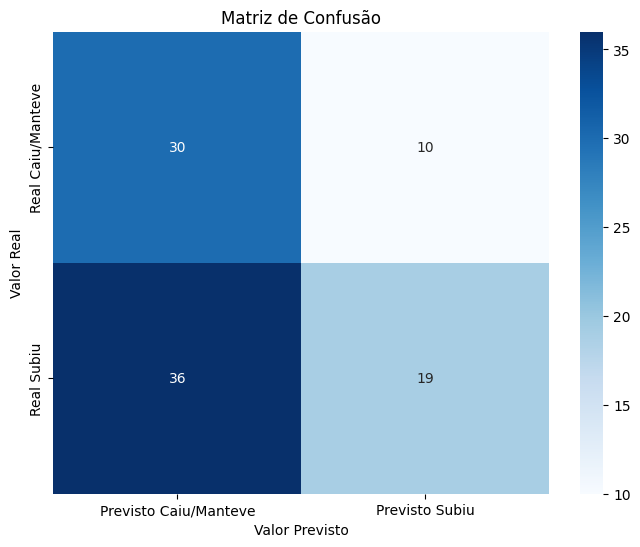

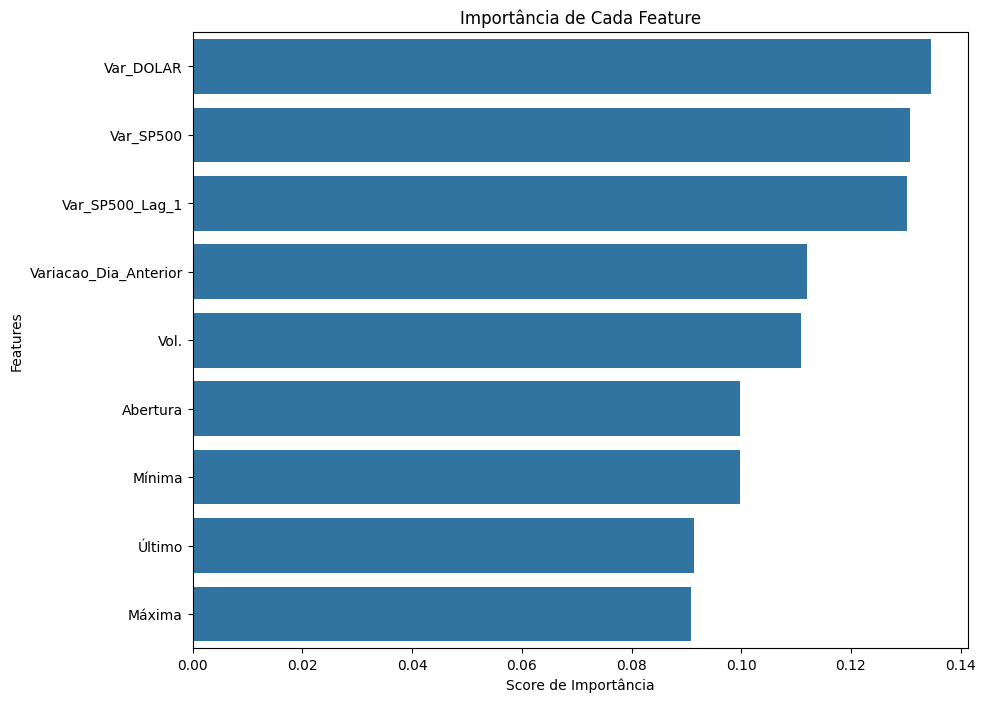

In [1224]:
# Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()

## Adicionando mais dados

1.   Volatilidade histórica
2.   Distância para média móvel de 200 dias



In [1225]:
# Calculando a volatilidade histórica (desvio padrão dos retornos) em janelas de 5 e 21 dias
dados['Volatilidade_5D'] = dados['Último'].pct_change().rolling(window=5).std()
dados['Volatilidade_21D'] = dados['Último'].pct_change().rolling(window=21).std()

In [1226]:
# Distância para a média móvel de 200 dias (uma tendência de longo prazo)
dados['SMA_200'] = dados['Último'].rolling(window=200).mean()
dados['Distancia_SMA200'] = dados['Último'] / dados['SMA_200'] # Se > 1, está acima da tendência

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [1227]:
dados

,Último,Abertura,Máxima,Mínima,Vol.,Target,Variacao_Dia_Anterior,Var_SP500,Var_DOLAR,Var_PETROLEO,Var_SP500_Lag_1,Var_DOLAR_Lag_1,Var_PETROLEO_Lag_1,Volatilidade_5D,Volatilidade_21D,SMA_200,Distancia_SMA200
Data,,,,,,,,,,,,,,,,,
2024-05-07,129.210,128.466,129.745,128.464,10180000,1,0.005791,0.001343,0.000789,-0.001274,0.010326,-0.007710,0.004737,0.009026,0.008603,123.301535,1.047919
2024-05-08,129.481,129.210,129.564,128.048,9790000,0,0.002097,-0.000006,-0.000315,0.007783,0.001343,0.000789,-0.001274,0.004771,0.007864,123.361810,1.049604
2024-05-09,128.188,129.468,129.468,127.376,13370000,0,-0.009986,0.005091,0.002878,0.003418,-0.000006,-0.000315,0.007783,0.007785,0.007957,123.408260,1.038731
2024-05-10,127.600,128.188,129.022,127.467,12570000,1,-0.004587,0.001649,0.010397,-0.012617,0.005091,0.002878,0.003418,0.006102,0.007398,123.456550,1.033562
2024-05-13,128.155,127.600,128.669,127.599,8920000,1,0.004350,-0.000241,-0.003412,0.010989,0.001649,0.010397,-0.012617,0.006643,0.007367,123.509545,1.037612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,136.866,137.113,137.209,136.469,6240000000,1,-0.001809,0.005219,-0.014538,0.004292,0.008020,0.008638,0.004929,0.007781,0.006747,130.262210,1.050696
2025-06-30,138.855,136.865,139.103,136.430,7680000000,1,0.014532,0.005164,0.000237,-0.006258,0.005219,-0.014538,0.004292,0.009741,0.007498,130.276050,1.065852
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0,0.004998,-0.001119,-0.008798,0.005222,0.005164,0.000237,-0.006258,0.009758,0.007123,130.291475,1.071052


In [1228]:
print("--- Verificando as colunas em X ANTES do treino ---")
print(X_treino.columns.tolist())

# Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target',
                                                        'Var_PETROLEO',
                                                         'Var_PETROLEO_Lag_1']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


# Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

# Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

print("\n\n--- Verificando as colunas em X UTILIZADAS no treino ---")
print(X_treino.columns.tolist())

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n\n\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

--- Verificando as colunas em X ANTES do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior', 'Var_SP500', 'Var_DOLAR', 'Var_SP500_Lag_1']

Tamanho do conjunto de Treino: 217 amostras
Tamanho do conjunto de Teste: 55 amostras


--- Verificando as colunas em X UTILIZADAS no treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior', 'Var_SP500', 'Var_DOLAR', 'Var_SP500_Lag_1', 'Var_DOLAR_Lag_1', 'Volatilidade_5D', 'Volatilidade_21D', 'SMA_200', 'Distancia_SMA200']



--- Resultados da Avaliação ---
Acurácia do Modelo: 50.91%


## Selecionando as melhores

In [1229]:
from sklearn.feature_selection import SelectKBest, f_classif
# Supondo que você já tenha o pandas, numpy e seu modelo importado

In [1230]:
K = 10

# 1. Inicializar o seletor
# Usamos f_classif porque seu problema é de classificação.
seletor = SelectKBest(score_func=f_classif, k=K)

# 2. Ajustar o seletor aos dados de TREINO para que ele aprenda quais são as melhores features
print(f"Ajustando o seletor para encontrar as {K} melhores features...")
seletor.fit(X_treino, y_treino)

# 3. (Opcional, mas muito útil) Ver quais features foram selecionadas
features_selecionadas_mask = seletor.get_support() # Retorna um array de True/False
features_selecionadas_nomes = X_treino.columns[features_selecionadas_mask]

print("\n--- Features Selecionadas pelo SelectKBest ---")
print(features_selecionadas_nomes.tolist())

# 4. Transformar (filtrar) os conjuntos de treino e teste para manter apenas as features selecionadas
print("\nAplicando a transformação aos dados...")
X_treino_novo = seletor.transform(X_treino)
X_teste_novo = seletor.transform(X_teste)

print(f"\nFormato original de X_treino: {X_treino.shape}")
print(f"Novo formato de X_treino: {X_treino_novo.shape}") # Deve ter K colunas

Ajustando o seletor para encontrar as 10 melhores features...

--- Features Selecionadas pelo SelectKBest ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior', 'Var_SP500', 'Var_DOLAR', 'Volatilidade_21D', 'Distancia_SMA200']

Aplicando a transformação aos dados...

Formato original de X_treino: (217, 14)
Novo formato de X_treino: (217, 10)


In [1231]:
# Supondo que 'modelo_campeao' seja o seu melhor modelo até agora (ex: RandomForest)
# Se você não o tiver, inicialize um novo:

modelo_campeao = RandomForestClassifier(random_state=42)

print("\nTreinando o modelo com o novo conjunto de features selecionadas...")
modelo_campeao.fit(X_treino_novo, y_treino)

# Fazer previsões e avaliar
previsoes_novo = modelo_campeao.predict(X_teste_novo)
acuracia_nova = accuracy_score(y_teste, previsoes_novo)

print(f"Acurácia com as {K} melhores features: {acuracia_nova:.2%}")


Treinando o modelo com o novo conjunto de features selecionadas...
Acurácia com as 10 melhores features: 60.00%
